In [ ]:
# LSTM (forget gate, input gate, cell state, ouput gate)가 은닉층에 구성
# 데이터 로드 및 분포 확인 -> 데이터 전처리 -> 데이터 생성 -> 순환신경망 모델 구축 및 학습
# 삼성전자 주식 관련 수정 종가 예측 프로그램
# referece : https://www.youtube.com/watch?v=LLLVYkXJw30&list=PLS8gIc2q83OhM0RTktKDitgZGX5dHo7Vs&index=23

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [9]:
df = pd.read_csv('samsung.csv')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-01,3160.0,3160.0,3160.0,3160.0,2429.165527,0
1,2001-01-02,3160.0,3380.0,3140.0,3350.0,2575.222412,39455000
2,2001-01-03,3230.0,3420.0,3220.0,3370.0,2590.597656,37855000
3,2001-01-04,3790.0,3870.0,3660.0,3780.0,2905.773926,119910000
4,2001-01-05,3760.0,3920.0,3700.0,3900.0,2998.020020,78135000


In [10]:
# 이동 평균선 추가
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA15'] = df['Close'].rolling(window=15).mean()
df.head(20)

,Date,Open,High,Low,Close,Adj Close,Volume,MA10,MA15
0,2001-01-01,3160.0,3160.0,3160.0,3160.0,2429.165527,0,NaN,NaN
1,2001-01-02,3160.0,3380.0,3140.0,3350.0,2575.222412,39455000,NaN,NaN
2,2001-01-03,3230.0,3420.0,3220.0,3370.0,2590.597656,37855000,NaN,NaN
3,2001-01-04,3790.0,3870.0,3660.0,3780.0,2905.773926,119910000,NaN,NaN
4,2001-01-05,3760.0,3920.0,3700.0,3900.0,2998.020020,78135000,NaN,NaN
5,2001-01-08,3820.0,3910.0,3780.0,3880.0,2982.646484,42295000,NaN,NaN
6,2001-01-09,3830.0,3860.0,3710.0,3840.0,2951.896973,46280000,NaN,NaN
7,2001-01-10,3780.0,3810.0,3700.0,3710.0,2851.962891,41235000,NaN,NaN
8,2001-01-11,3790.0,3790.0,3640.0,3640.0,2798.152832,31410000,NaN,NaN
9,2001-01-12,3800.0,3890.0,3770.0,3840.0,2951.896973,52900000,3647.0,NaN


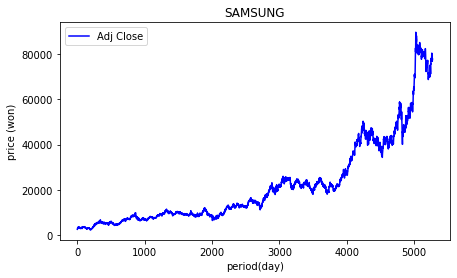

In [15]:
plt.figure(figsize=(7,4))

plt.title('SAMSUNG')
plt.ylabel('price (won)')
plt.xlabel('period(day)')

plt.plot(df['Adj Close'], label='Adj Close', color='b')
plt.legend(loc='best')

plt.show()

In [22]:
# 데이터 전처리 
# outlier, missing value 데이터 삭제
df.describe() # 거래량 0인거 발견

# 0값을 nan으로 대체
df['Volume'] = df['Volume'].replace(0, np.nan)

## 확인
for col in df.columns:
    missing_rows = df.loc[df[col] ==0].shape[0]
    print(col + ': ' + str(missing_rows))


Date: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 0
MA10: 0
MA15: 0


In [23]:
df.isnull().sum()
## nan volume에 94개 존재 

Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume       94
MA10          9
MA15         14
dtype: int64

In [29]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,MA10,MA15
count,5167.000000,5167.000000,5167.000000,5167.000000,5167.000000,5.167000e+03,5167.000000,5167.000000
mean,25388.283337,25648.374298,25123.590091,25385.149990,22280.028043,2.078140e+07,25321.803561,25285.977679
std,19420.728928,19592.202700,19245.688741,19408.887465,19195.900965,1.251289e+07,19344.978766,19308.921574
min,2760.000000,2810.000000,2680.000000,2810.000000,2160.112061,2.765000e+04,2835.000000,2887.333333
25%,11040.000000,11200.000000,10940.000000,11070.000000,8589.058106,1.192198e+07,11060.000000,11104.000000
50%,18200.000000,18380.000000,17960.000000,18200.000000,14794.230469,1.757455e+07,18116.000000,18084.000000
75%,31800.000000,32270.000000,31470.000000,31890.000000,27374.080078,2.598315e+07,31907.000000,32035.333333
max,90300.000000,96800.000000,89500.000000,91000.000000,89771.320313,1.313050e+08,88510.000000,87820.000000


In [31]:
df.loc[df['MA10'].isna()]
df.loc[df['MA15'].isna()]

,Date,Open,High,Low,Close,Adj Close,Volume,MA10,MA15


In [48]:
# 정규화 날짜를 제외한 나머지 숫자에 대해서 모든컬럼에 0~1값으로 정규화 수행
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# 날짜를 제외한 컬럼 가져오기
scale_cols = df.columns.values.tolist()[1:]

# 정규화 수행
scaled_df = scaler.fit_transform(df[scale_cols]) 

# numpy 리턴
print(type(scaled_df))

# 정규화된 데이터 프레임 생성
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)
print(scaled_df)



<class 'numpy.ndarray'>
          Open      High       Low     Close  Adj Close    Volume      MA10  \
0     0.022161  0.020109  0.021193  0.020297   0.015706  0.412999  0.013820   
1     0.021019  0.019045  0.020617  0.019730   0.015267  0.321627  0.014602   
2     0.019305  0.017768  0.014858  0.013267   0.010266  0.693169  0.017636   
3     0.014165  0.013725  0.014743  0.013720   0.010617  0.359676  0.017753   
4     0.015307  0.014470  0.016010  0.014741   0.011407  0.299536  0.017718   
...        ...       ...       ...       ...        ...       ...       ...   
5162  0.868631  0.812746  0.870997  0.860528   0.873631  0.094455  0.890516   
5163  0.868631  0.810618  0.849113  0.845788   0.858793  0.193811  0.890867   
5164  0.844642  0.795723  0.851417  0.840118   0.853086  0.098298  0.889466   
5165  0.860635  0.804234  0.860631  0.855993   0.869066  0.115299  0.888182   
5166  0.860635  0.801043  0.857176  0.849189   0.862217  0.055050  0.885614   

          MA15  
0     0.01

In [52]:
# 입력데이터
feature_cols = ['MA10', 'MA15', 'Adj Close'] 
## 정답데이터
label_cols = ['Adj Close']  

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

print(feature_df, label_df)

          MA10      MA15  Adj Close
0     0.013820  0.011334   0.015706
1     0.014602  0.012426   0.015267
2     0.017636  0.014961   0.010266
3     0.017753  0.015071   0.010617
4     0.017718  0.015283   0.011407
...        ...       ...        ...
5162  0.890516  0.891051   0.873631
5163  0.890867  0.891522   0.858793
5164  0.889466  0.891443   0.853086
5165  0.888182  0.891993   0.869066
5166  0.885614  0.891914   0.862217

[5167 rows x 3 columns]       Adj Close
0      0.015706
1      0.015267
2      0.010266
3      0.010617
4      0.011407
...         ...
5162   0.873631
5163   0.858793
5164   0.853086
5165   0.869066
5166   0.862217

[5167 rows x 1 columns]


In [57]:
# 딥러닝 학습을 위한 넘파이로 변환
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape)

(5167, 3) (5167, 1)


In [59]:
def make_sequence_dataset(feature, label, window_size):
    
    feature_list = [] 
    label_list = []
    
    for i in range(len(feature) - window_size):
        
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])
           #3차원 텐서 변환 
    return np.array(feature_list), np.array(label_list)

In [62]:
## 시계열 데이터 생성
window_size = 40

X, Y = make_sequence_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)

(5127, 40, 3) (5127, 1)


In [65]:
## 데이터 나누기 
split = -200

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4927, 40, 3) (4927, 1)
(200, 40, 3) (200, 1)


In [66]:
## LSTM 모델 구축

model = Sequential()

model.add(LSTM(128,
               activation='tanh',
               input_shape=x_train[0].shape))

model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [67]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
## 특정값이 올때까지 조기 종료
early_stop = EarlyStopping(monitor='val_loss', patience=5)

hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, callbacks=[early_stop])

Epoch 1/100
308/308 [==============================] - 20s 55ms/step - loss: 0.0014 - mae: 0.0147 - val_loss: 5.6234e-04 - val_mae: 0.0180
Epoch 2/100
308/308 [==============================] - 16s 52ms/step - loss: 1.7019e-04 - mae: 0.0080 - val_loss: 7.7627e-04 - val_mae: 0.0225
Epoch 3/100
308/308 [==============================] - 16s 53ms/step - loss: 1.5264e-04 - mae: 0.0078 - val_loss: 4.5518e-04 - val_mae: 0.0163
Epoch 4/100
308/308 [==============================] - 16s 53ms/step - loss: 1.2296e-04 - mae: 0.0072 - val_loss: 0.0011 - val_mae: 0.0292
Epoch 5/100
308/308 [==============================] - 20s 64ms/step - loss: 1.1540e-04 - mae: 0.0069 - val_loss: 3.2272e-04 - val_mae: 0.0136
Epoch 6/100
308/308 [==============================] - 20s 64ms/step - loss: 1.0039e-04 - mae: 0.0065 - val_loss: 3.0785e-04 - val_mae: 0.0132
Epoch 7/100
308/308 [==============================] - 19s 61ms/step - loss: 8.4814e-05 - mae: 0.0059 - val_loss: 3.3999e-04 - val_mae: 0.0143
Epoch 8

In [68]:
model.evaluate(x_test, y_test)

7/7 [==============================] - 0s 36ms/step - loss: 3.5171e-04 - mae: 0.0162


[0.00035170518094673753, 0.016218097880482674]

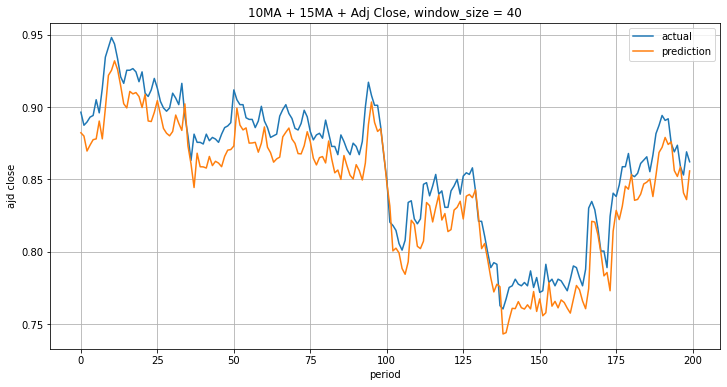

In [69]:
pred = model.predict(x_test)

plt.figure(figsize=(12,6))
plt.title('10MA + 15MA + Adj Close, window_size = 40')
plt.ylabel('ajd close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [71]:
feature_df

,MA10,MA15,Adj Close
0,0.013820,0.011334,0.015706
1,0.014602,0.012426,0.015267
2,0.017636,0.014961,0.010266
3,0.017753,0.015071,0.010617
4,0.017718,0.015283,0.011407
...,...,...,...
5162,0.890516,0.891051,0.873631
5163,0.890867,0.891522,0.858793
5164,0.889466,0.891443,0.853086
5165,0.888182,0.891993,0.869066
